# Plotting with geopandas

In [1]:
import json
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap
import random

file_path = "mapdata/INDIA_DISTRICTS_TOPO.json" 
gdf = gpd.read_file(file_path)
# Ensure state and district codes are integers for consistency
gdf['stcode11'] = gdf['stcode11'].astype(int)
gdf['dtcode11'] = gdf['dtcode11'].astype(int)

print(f'Data loaded in the format : {type(gdf)}')

state_color_dict = None
coordinates_dict = None
with open('mydata/state_colors.json', 'r') as f:           state_color_dict = json.load(f)
with open('mydata/major_city_coordinates.json', 'r') as f: coordinates_dict = json.load(f)
print(f'json data loaded.')

Data loaded in the format : <class 'geopandas.geodataframe.GeoDataFrame'>
json data loaded.


### gdf dataframe structure

In [2]:
print(gdf.columns)

Index(['id', 'dtname', 'stname', 'stcode11', 'dtcode11', 'year_stat',
       'SHAPE_Length', 'SHAPE_Area', 'OBJECTID', 'test', 'Dist_LGD',
       'State_LGD', 'geometry'],
      dtype='object')


### gdf containing states

In [3]:
### List all the states in the dataframe:
states_list = np.sort(gdf['stname'].unique()).tolist()
print('-'*20+'\n'+f'List of {len(states_list)} states:'+'\n'+'-'*20)
print(states_list)

### Create another dataframe by merging the districts in each state.
invalid_geometries = gdf[~gdf.is_valid]
gdf['geometry'] = gdf['geometry'].buffer(0)
gdf_states = gdf.dissolve(by='stname')
gdf_states = gdf_states.reset_index()
gdf_states['color'] = gdf_states['stname'].map(lambda x: state_color_dict.get(x, 'gray'))

print('\nColumns:')
display(print(gdf_states.columns))

--------------------
List of 36 states:
--------------------
['ANDAMAN & NICOBAR', 'ANDHRA PRADESH', 'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHANDIGARH', 'CHHATTISGARH', 'DADRA,NAGAR HAVELI,DAMAN & DIU', 'DELHI', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'JHARKHAND', 'KARNATAKA', 'KERALA', 'LADAKH', 'LAKSHADWEEP', 'MADHYA PRADESH', 'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND', 'ODISHA', 'PUDUCHERRY', 'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMIL NADU', 'TELANGANA', 'TRIPURA', 'UTTAR PRADESH', 'UTTARAKHAND', 'WEST BENGAL']

Columns:
Index(['stname', 'geometry', 'id', 'dtname', 'stcode11', 'dtcode11',
       'year_stat', 'SHAPE_Length', 'SHAPE_Area', 'OBJECTID', 'test',
       'Dist_LGD', 'State_LGD', 'color'],
      dtype='object')


None

## Load additional data from spreadsheet

### 1. Census data (2011)

In [4]:
excel_file = 'opendata_fromGov/A-1_NO_OF_VILLAGES_TOWNS_HOUSEHOLDS_POPULATION_AND_AREA.xlsx'
census2011_df = pd.read_excel(excel_file, sheet_name='Sheet1', engine='openpyxl', header=3) # Skips first 3 rows
# Rename the columns
census2011_df.columns = [
    'State Code',             # 1
    'District Code',          # 2
    'Sub District Code',      # 3
    'Region Type',            # 4
    'Name',                   # 5
    'Total/Rural/Urban',      # 6
    'Villages Inhabited',     # 7
    'Villages Uninhabited',   # 8
    'Number of Towns',        # 9
    'Number of Households',   # 10
    'Population Persons',     # 11
    'Population Males',       # 12
    'Population Females',     # 13
    'Area (sq. km)',          # 13.00
    'Population Density'      # 14
]

# Filter the rows where 'Region Type'
census2011_df = census2011_df.drop(columns=['Sub District Code'])
#census2011_df['State Code'] = census2011_df['State Code'].astype(int)
#census2011_df['District Code'] = census2011_df['District Code'].astype(int)

census2011_df_dist  = census2011_df[census2011_df['Region Type'] == 'DISTRICT']
census2011_df_state = census2011_df[census2011_df['Region Type'] == 'STATE']

print('2011 census data loaded.')

2011 census data loaded.


In [8]:
# Now split the data into Total, Rural, and Urban, rename the colmns (add suffixes) and combine them back.|
def split_into_3(census_df):
    total_df = census_df[census_df['Total/Rural/Urban'] == 'Total']
    rural_df = census_df[census_df['Total/Rural/Urban'] == 'Rural']
    urban_df = census_df[census_df['Total/Rural/Urban'] == 'Urban']
    
    suffixes = ['total', 'rural', 'urban']
    columns_of_interest = [
        'Villages Inhabited', 'Villages Uninhabited', 'Number of Towns', 
        'Number of Households', 'Population Persons', 'Population Males', 
        'Population Females', 'Area (sq. km)', 'Population Density'
    ]
    
    def rename_columns(df, suffix):
        return df.rename(columns={
            col: f"{col} {suffix}" for col in columns_of_interest
        })
        
    total_df = rename_columns(total_df, 'total')
    rural_df = rename_columns(rural_df, 'rural')
    urban_df = rename_columns(urban_df, 'urban')
    
    #Merge and arrange the columns:
    merged_df = total_df.merge(rural_df, on=['State Code', 'District Code'],  how='outer')
    merged_df = merged_df.merge(urban_df, on=['State Code', 'District Code'], how='outer')
    
    # Drop duplicate columns:
    merged_df = merged_df.drop(columns=[
        'Region Type','Region Type_x', 'Region Type_y',
        'Total/Rural/Urban','Total/Rural/Urban_x', 'Total/Rural/Urban_y', 
        'Name_x', 'Name_y'
    ])
    
    # Reordering the colmns:
    columns_order = ['State Code', 'District Code', 'Name']
    for var in columns_of_interest:
        total_col = f'{var} total'
        rural_col = f'{var} rural'
        urban_col = f'{var} urban'
        columns_order += [total_col, rural_col, urban_col]
    
    merged_df = merged_df[columns_order]
    return merged_df
    
census2011_df_dist = split_into_3(census2011_df_dist)
census2011_df_state = split_into_3(census2011_df_state)
census2011_df_state = census2011_df_state.sort_values(by='Name')
census2011_df_state = census2011_df_state.reset_index(drop=True)
print('Columns are rearranged. Each row contain district data.')

Columns are rearranged. Each row contain district data.


In [9]:
census2011_df_dist.columns

Index(['State Code', 'District Code', 'Name', 'Villages Inhabited total',
       'Villages Inhabited rural', 'Villages Inhabited urban',
       'Villages Uninhabited total', 'Villages Uninhabited rural',
       'Villages Uninhabited urban', 'Number of Towns total',
       'Number of Towns rural', 'Number of Towns urban',
       'Number of Households total', 'Number of Households rural',
       'Number of Households urban', 'Population Persons total',
       'Population Persons rural', 'Population Persons urban',
       'Population Males total', 'Population Males rural',
       'Population Males urban', 'Population Females total',
       'Population Females rural', 'Population Females urban',
       'Area (sq. km) total', 'Area (sq. km) rural', 'Area (sq. km) urban',
       'Population Density total', 'Population Density rural',
       'Population Density urban'],
      dtype='object')

In [10]:
census2011_df_state[['State Code', 'District Code', 'Name', 'Population Persons total',
       'Population Persons rural', 'Population Persons urban']].head()

,State Code,District Code,Name,Population Persons total,Population Persons rural,Population Persons urban
0,35.0,000,ANDAMAN & NICOBAR ISLANDS,380581.0,237093.0,143488.0
1,28.0,000,ANDHRA PRADESH,84580777.0,56361702.0,28219075.0
2,12.0,000,ARUNACHAL PRADESH,1383727.0,1066358.0,317369.0
3,18.0,000,ASSAM,31205576.0,26807034.0,4398542.0
4,10.0,000,BIHAR,104099452.0,92341436.0,11758016.0


In [11]:
print('Name of states in the Excel file:')
print(list(census2011_df_state['Name']))

Name of states in the Excel file:
['ANDAMAN & NICOBAR ISLANDS', 'ANDHRA PRADESH', 'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHANDIGARH', 'CHHATTISGARH', 'DADRA & NAGAR HAVELI', 'DAMAN & DIU', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'JHARKHAND', 'KARNATAKA', 'KERALA', 'LAKSHADWEEP', 'MADHYA PRADESH', 'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND', 'NCT OF DELHI', 'ODISHA', 'PUDUCHERRY', 'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMIL NADU', 'TRIPURA', 'UTTAR PRADESH', 'UTTARAKHAND', 'WEST BENGAL']


### Combining state data from dataframe and census

In [12]:
def combine_regions(gdf, regions_to_merge, new_name, dissolve_by='stname', aggfunc='first'):

    if not gdf.is_valid.all(): gdf['geometry'] = gdf['geometry'].buffer(0)
    regions_to_merge_gdf = gdf[gdf[dissolve_by].isin(regions_to_merge)]
    
    # Merge geometries using unary_union
    merged_geometry = regions_to_merge_gdf.geometry.union_all()
    merged_row = {
        dissolve_by: new_name,
        'geometry': merged_geometry
    }
    
    # Handle numeric attributes (sum or mean where appropriate)
    for col in gdf.columns:
        if col not in [dissolve_by, 'geometry']:
            if pd.api.types.is_numeric_dtype(gdf[col]): merged_row[col] = regions_to_merge_gdf[col].sum()
            else:merged_row[col] = regions_to_merge_gdf[col].iloc[0]  # Keep first value for non-numeric
    
    # Convert merged_row to a DataFrame
    merged_row_gdf = gpd.GeoDataFrame([merged_row], columns=gdf.columns)
    
    # Drop original regions and concatenate the new merged row
    gdf = gdf[~gdf[dissolve_by].isin(regions_to_merge)]
    gdf = pd.concat([gdf, merged_row_gdf], ignore_index=True)
    gdf = gdf.sort_values(by=dissolve_by).reset_index(drop=True)

    return gdf

# 1. Combine newly formed states to their older form:
print(gdf_states.columns)
gdf_states = combine_regions(gdf_states, ['TELANGANA', 'ANDHRA PRADESH'], 'ANDHRA PRADESH')

# 2. Combine old states which were later merged into one:
columns_to_combine = [
    'Villages Inhabited total', 'Villages Inhabited rural', 'Villages Inhabited urban',
    'Villages Uninhabited total', 'Villages Uninhabited rural', 'Villages Uninhabited urban',
    'Number of Towns total', 'Number of Towns rural', 'Number of Towns urban',
    'Number of Households total', 'Number of Households rural', 'Number of Households urban',
    'Population Persons total', 'Population Persons rural', 'Population Persons urban',
    'Population Males total', 'Population Males rural', 'Population Males urban',
    'Population Females total', 'Population Females rural', 'Population Females urban',
    'Area (sq. km) total', 'Area (sq. km) rural', 'Area (sq. km) urban',
    'Population Density total', 'Population Density rural', 'Population Density urban'
]
census2011_df_state.loc[census2011_df_state['Name'].isin(['DADRA & NAGAR HAVELI', 'DAMAN & DIU']), 'Name'] = 'DADRA,NAGAR HAVELI,DAMAN & DIU'
agg_data = census2011_df_state[census2011_df_state['Name'].isin(['DADRA & NAGAR HAVELI', 'DAMAN & DIU'])]
agg_combined = agg_data.groupby('Name').agg(
    {col: 'sum' if pd.Series(col).str.contains('Population|Households|Towns|Villages').any() else 'mean' 
     for col in columns_to_combine}
).reset_index()
census2011_df_state.loc[census2011_df_state['Name'].isin(['DADRA & NAGAR HAVELI', 'DAMAN & DIU']), 'Name'] = 'DADRA,NAGAR HAVELI,DAMAN & DIU'
census2011_df_state = census2011_df_state.merge(agg_combined, on='Name', how='left', suffixes=('', '_combined'))

# 3. Name changes:
# Map for updating region names
name_changes = {
    'ANDAMAN & NICOBAR': 'ANDAMAN & NICOBAR ISLANDS',
    'DELHI': 'NCT OF DELHI',
}

# Apply the name changes to the 'stname' column
gdf_states['stname'] = gdf_states['stname'].replace(name_changes)

print('\nStates in the geo-dataframe:')
print(sorted(set(gdf_states['stname'])))
print('\nStates in the 2011 census data:')
print(sorted(set(census2011_df_state['Name'])))

print('\nGeoDataFrame and Excel data ready to merge.')

Index(['stname', 'geometry', 'id', 'dtname', 'stcode11', 'dtcode11',
       'year_stat', 'SHAPE_Length', 'SHAPE_Area', 'OBJECTID', 'test',
       'Dist_LGD', 'State_LGD', 'color'],
      dtype='object')

States in the geo-dataframe:
['ANDAMAN & NICOBAR ISLANDS', 'ANDHRA PRADESH', 'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHANDIGARH', 'CHHATTISGARH', 'DADRA,NAGAR HAVELI,DAMAN & DIU', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'JHARKHAND', 'KARNATAKA', 'KERALA', 'LADAKH', 'LAKSHADWEEP', 'MADHYA PRADESH', 'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND', 'NCT OF DELHI', 'ODISHA', 'PUDUCHERRY', 'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMIL NADU', 'TRIPURA', 'UTTAR PRADESH', 'UTTARAKHAND', 'WEST BENGAL']

States in the 2011 census data:
['ANDAMAN & NICOBAR ISLANDS', 'ANDHRA PRADESH', 'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHANDIGARH', 'CHHATTISGARH', 'DADRA,NAGAR HAVELI,DAMAN & DIU', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'JHARKHAND

In [13]:
#Idiot proofing: Dropping columns if they are already there to avoid repetition
columns_to_drop = columns_to_combine
if columns_to_drop:
    print(f"Dropping existing columns: {columns_to_drop}")
    gdf_states = gdf_states.drop(columns=[col for col in columns_to_drop if col in gdf_states.columns])
else: print("No columns to drop. Preparing to merge.")

# Now, merge the census data into gdf_states
gdf_states = gdf_states.merge(census2011_df_state[['Name'] + columns_to_combine], left_on='stname', right_on='Name', how='left')
#gdf_states = gdf_states.drop(columns=['Name'])
print("\n\nMerge successfu!")

Dropping existing columns: ['Villages Inhabited total', 'Villages Inhabited rural', 'Villages Inhabited urban', 'Villages Uninhabited total', 'Villages Uninhabited rural', 'Villages Uninhabited urban', 'Number of Towns total', 'Number of Towns rural', 'Number of Towns urban', 'Number of Households total', 'Number of Households rural', 'Number of Households urban', 'Population Persons total', 'Population Persons rural', 'Population Persons urban', 'Population Males total', 'Population Males rural', 'Population Males urban', 'Population Females total', 'Population Females rural', 'Population Females urban', 'Area (sq. km) total', 'Area (sq. km) rural', 'Area (sq. km) urban', 'Population Density total', 'Population Density rural', 'Population Density urban']


Merge successfu!


In [14]:
gdf_states.columns

Index(['stname', 'geometry', 'id', 'dtname', 'stcode11', 'dtcode11',
       'year_stat', 'SHAPE_Length', 'SHAPE_Area', 'OBJECTID', 'test',
       'Dist_LGD', 'State_LGD', 'color', 'Name', 'Villages Inhabited total',
       'Villages Inhabited rural', 'Villages Inhabited urban',
       'Villages Uninhabited total', 'Villages Uninhabited rural',
       'Villages Uninhabited urban', 'Number of Towns total',
       'Number of Towns rural', 'Number of Towns urban',
       'Number of Households total', 'Number of Households rural',
       'Number of Households urban', 'Population Persons total',
       'Population Persons rural', 'Population Persons urban',
       'Population Males total', 'Population Males rural',
       'Population Males urban', 'Population Females total',
       'Population Females rural', 'Population Females urban',
       'Area (sq. km) total', 'Area (sq. km) rural', 'Area (sq. km) urban',
       'Population Density total', 'Population Density rural',
       'Population

In [15]:
gdf_states[['stname','stcode11','Population Persons total','Population Persons rural', 'Population Persons urban',]].head()

,stname,stcode11,Population Persons total,Population Persons rural,Population Persons urban
0,ANDAMAN & NICOBAR ISLANDS,35,380581.0,237093.0,143488.0
1,ANDHRA PRADESH,73,84580777.0,56361702.0,28219075.0
2,ARUNACHAL PRADESH,12,1383727.0,1066358.0,317369.0
3,ASSAM,18,31205576.0,26807034.0,4398542.0
4,BIHAR,10,104099452.0,92341436.0,11758016.0


---

## Plotting with data

At this point, we have three dataframes.
- `gdf`        : Original dataframe containing district level information.
- `gdf_states` : New dataframe with the districts combined for each state.
- `gdf_mystate`: Specific dataframe for one state containing district level information.

In [16]:
def plot_column(gdf_states,
                column_name,
                colormap='summer',
                reverse=False,
                figsize=(6, 6),
                legendheader="",
                plottitle=""):

    cmap = plt.colormaps[colormap]
    if reverse:
        n_colors = 256  # The number of discrete color levels
        colors = cmap(np.linspace(0, 1, n_colors))  # Get the colors
        cmap = ListedColormap(colors[::-1])  # Reverse the colormap
        
    norm = Normalize(vmin=gdf_states[column_name].min(), vmax=gdf_states[column_name].max())

    # Handling missing data:
    missing_data_mask = gdf_states[column_name].isna()
    colors = cmap(np.linspace(0, 1, 255))
    gray_cmap = ListedColormap(np.vstack([[[0.5, 0.5, 0.5, 1]], colors]))

    fig, ax = plt.subplots(figsize=figsize)
    gdf_states.plot(ax=ax, column=column_name, cmap=cmap, edgecolor='black', linewidth=0.5, legend=False)
    gdf_states[missing_data_mask].plot(ax=ax, color='gray', edgecolor='black', linewidth=0.5, legend=False) # Plot NaN values in gray

    ax.set_title(plottitle, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values(): spine.set_visible(False)
    ax.grid(False)

    # Add a colorbar with a smaller size
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Necessary for the colorbar
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)  # Adjust fraction and pad to make it smaller
    cbar.set_label(legendheader, fontsize=12)
    cbar.ax.tick_params(labelsize=8)  # Make the colorbar ticks smaller
    cbar.ax.yaxis.set_ticks_position('right')  # Move ticks to the right
    cbar.ax.tick_params(labelleft=False, labelright=True)  # Show labels on the right

    plt.tight_layout()
    plt.show()

print('Function ready!')

Function ready!


### Examples

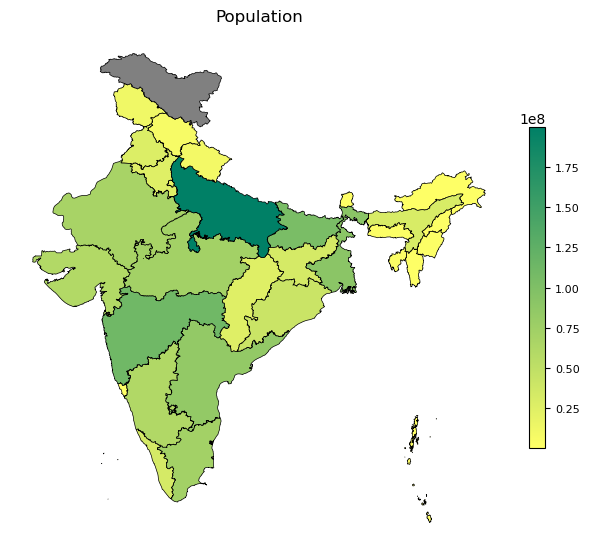

In [17]:
plot_column(gdf_states,
            column_name='Population Persons total',#'Year',
            colormap='summer',
            reverse=True,
            plottitle='Population')